# Dec 31st, 2022 (AD: register using S2PT, $25\mu m$)

**Motivation**: Template works better than nissl, what about 25 vs 100 $\mu m$?

***Conclusions***:
- template is better than nissl, and
- $25 \mu m$ is better than $100 \mu m$ <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
def coronal():
    slices = range(1, 81, 4)

    ncols = 5
    nrows = int(np.ceil(len(slices) / ncols))
    fig, axes = create_figure(nrows, ncols, (ncols * 2.5, nrows * 2), 'all', 'all', constrained_layout=True)
    for i, s_ in enumerate(slices):
        ax = axes.flat[i]
        ax.annotate(
            text=s_,
            xy=(0.01, 0.9),
            xycoords='axes fraction',
            color='cyan',
        )
        ax.imshow(reg.in_house[s_], cmap='Greys_r')
        ax.imshow(mwh(obj[s_] == 0, obj[s_]), alpha=0.8, vmin=1.5, vmax=3.5, cmap='Spectral_r')
    remove_ticks(axes, False)
    plt.show()
    
    
def _apply():
    obj = ants.apply_transforms(
        fixed=affined,
        moving=reg.img_in_ccf(mask),
        transformlist=tx['invtransforms'],
        interpolator='genericLabel',
    )
    obj = tx_aff_inv.apply_to_image(
        image=obj,
        reference=reg.in_house,
        interpolation='multilabel',
    )
    obj = obj.numpy()
    for i_new, i in enumerate(np.unique(obj[obj.nonzero()])):
        obj[obj == i] = i_new + 1
    return obj

In [3]:
from register.register import Register, reset_ants_img

mice = Mice(Config(128, resolution=25), load_parcel=True, load_allen=True)

reg = Register(mice)
reg.mi_base = ants.image_mutual_information(
    image1=reg.template, image2=reg.template)

reg.in_house

[PROGRESS] 'config.json' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (81, 46, 60)
         Spacing    : (200.0, 200.0, 200.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [4]:
mice.al

╭──────────────────────────────────────────────────────────────────╮
│                         Allen mouse 25um                         │
│                                                                  │
│         name:  allen_mouse (v1.2)                                │
│      species:  Mus musculus                                      │
│     citation:  Wang et al 2020                                   │
│                https://doi.org/10.1016/j.cell.2020.04.007        │
│         link:  http://www.brain-map.org                          │
│                                                                  │
│  orientation:  asr                                               │
│    symmetric:  True                                              │
│   resolution:  [25.0, 25.0, 25.0]                                │
│        shape:  [528, 320, 456]                                   │
╰──────────────────────────────────────────────────────────────────╯

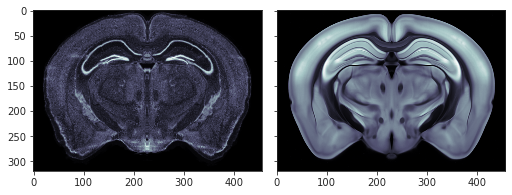

In [5]:
fig, axes = create_figure(1, 2, (7, 3), 'all', 'all', constrained_layout=True)
axes[0].imshow(reg.nissl[300], cmap='bone')
axes[1].imshow(reg.template[300], cmap='bone')
plt.show()

In [6]:
tx_fwd, tx_aff = reg.load_tx(reg.in_house_name, is_inv=False)
tx_inv, _ = reg.load_tx(reg.in_house_name, is_inv=True)
tx = {'fwdtransforms': tx_fwd, 'invtransforms': tx_inv}
tx_aff_inv = tx_aff.invert()

affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.template,
    interpolation='linear',
)
mask = mice.al.get_masks(['fiber tracts', 'VS', 'Isocortex'], as_objectmap=True)
mask.shape

(528, 320, 456)

In [7]:
scores, misc, warped = reg.tx_peformance(
    fixed=reg.template,
    moving=affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx=tx,
)
scores

{
    'mi': 0.551089256337447,
    'ovp_MOp': 1.0,
    'sym_MOp': 1.0,
    'ovp_MOs': 1.0,
    'sym_MOs': 0.9939117199391172,
    'ovp_SS': 1.0,
    'sym_SS': 0.9986366734832992,
    'ovp_VISC': 1.0,
    'sym_VISC': 1.0,
    'ovp_VIS': 1.0,
    'sym_VIS': 0.9967897271268058,
    'ovp_AI': 1.0,
    'sym_AI': 0.9974747474747475,
    'ovp_PTLp': 1.0,
    'sym_PTLp': 0.9509803921568627,
    'ovp_TEa': 1.0,
    'sym_TEa': 0.9699248120300752,
    'ovp_CA1': 1.0,
    'sym_CA1': 0.9979633401221996,
    'ovp_CLA': 1.0,
    'sym_CLA': 1.0,
    'ovp_STRd': 1.0,
    'sym_STRd': 0.9975083056478405,
    'ovp_iso': 1.0,
    'sym_iso': 0.9962010015541357,
    'sym': 0.9960617110315744,
    'ovp': 1.0
}

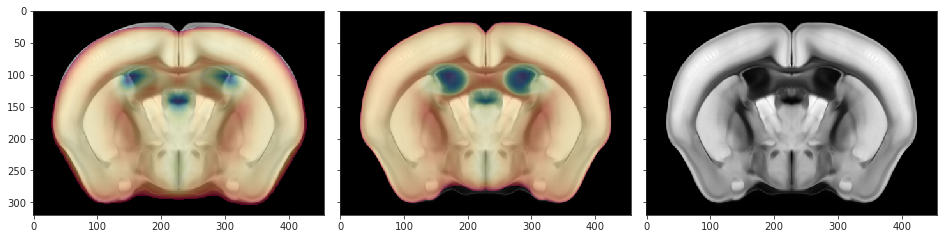

In [8]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.template[240], cmap='Greys_r')
axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')
plt.show()

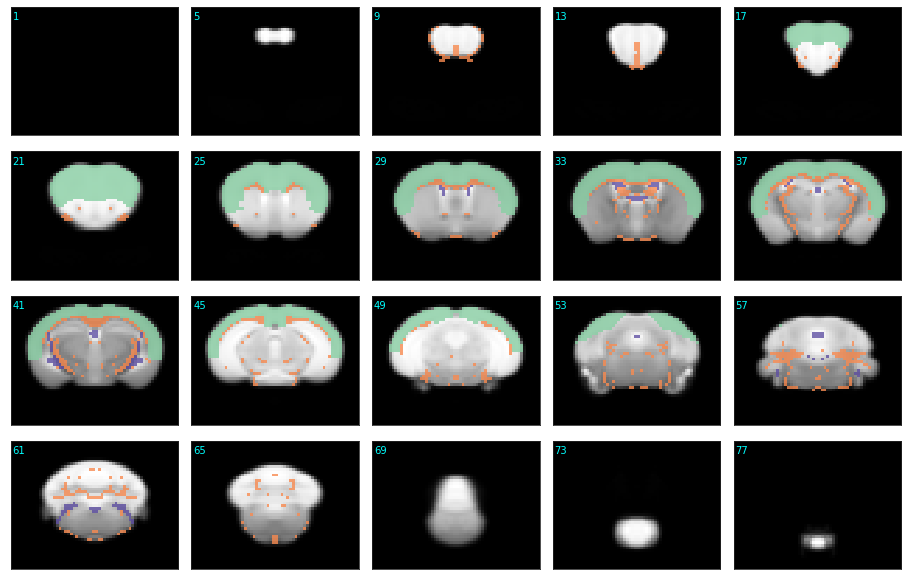

In [9]:
obj = _apply()
coronal()

## Try a $100 \mu m$ fit?

In [10]:
from register.register import Register, reset_ants_img
mice = Mice(Config(128, resolution=100), load_parcel=True, load_allen=True)

reg = Register(mice)
reg.mi_base = ants.image_mutual_information(
    image1=reg.template, image2=reg.template)

mask = mice.al.get_masks(['fiber tracts', 'VS', 'Isocortex'], as_objectmap=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

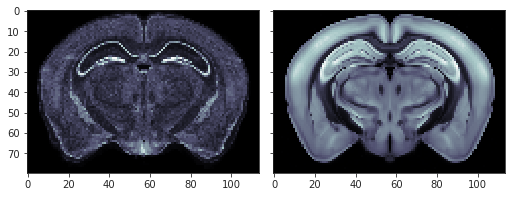

In [11]:
fig, axes = create_figure(1, 2, (7, 3), 'all', 'all', constrained_layout=True)
axes[0].imshow(reg.nissl[75], cmap='bone')
axes[1].imshow(reg.template[75], cmap='bone')
plt.show()

In [13]:
txfile = ants.affine_initializer(
    fixed_image=reg.template,
    moving_image=reg.in_house,
    search_factor=5,
    radian_fraction=0.10,
    use_principal_axis=False,
    local_search_iterations=10,
)
tx_aff = ants.read_transform(txfile)
affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.template,
    interpolation='linear',
)
mi = ants.image_mutual_information(
    image1=affined, image2=reg.template)
mi /= reg.mi_base
mi

0.41767356125830724

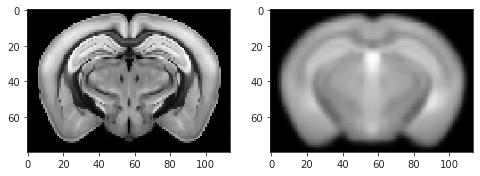

In [15]:
fig, axes = create_figure(1, 2, (8, 3.1))
slice_i = int(0.57 * reg.template.shape[0])
axes[0].imshow(reg.template[slice_i], cmap='Greys_r')
axes[1].imshow(affined[slice_i], cmap='Greys_r')
plt.show()

In [39]:
%%time

tx = ants.registration(
    fixed=reg.template,
    moving=affined,
    aff_metric='mattes',
    syn_metric='mattes',
    type_of_transform='ElasticSyN',
    grad_step=0.3,
    aff_sampling=32,
    aff_random_sampling_rate=0.4,
    syn_sampling=48,
    random_seed=0,
    verbose=False,
)
scores, misc, warped = reg.tx_peformance(
    fixed=reg.template,
    moving=affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx=tx,
)
obj = _apply()

CPU times: user 3min 6s, sys: 4.79 s, total: 3min 11s
Wall time: 13.5 s


In [40]:
scores

{
    'mi': 0.5259416138728357,
    'ovp_MOp': 1.0,
    'sym_MOp': 1.0,
    'ovp_MOs': 1.0,
    'sym_MOs': 0.9640933572710951,
    'ovp_SS': 1.0,
    'sym_SS': 0.9879735417919423,
    'ovp_VISC': 1.0,
    'sym_VISC': 0.9540229885057472,
    'ovp_VIS': 1.0,
    'sym_VIS': 0.9503205128205128,
    'ovp_AI': 1.0,
    'sym_AI': 0.9841688654353562,
    'ovp_PTLp': 1.0,
    'sym_PTLp': 0.9285714285714286,
    'ovp_TEa': 1.0,
    'sym_TEa': 0.9548872180451128,
    'ovp_CA1': 1.0,
    'sym_CA1': 0.9826086956521739,
    'ovp_CLA': 1.0,
    'sym_CLA': 0.9285714285714286,
    'ovp_STRd': 1.0,
    'sym_STRd': 0.9959141981613892,
    'ovp_iso': 1.0,
    'sym_iso': 0.9814877145742175,
    'sym': 0.9805230026095224,
    'ovp': 1.0
}

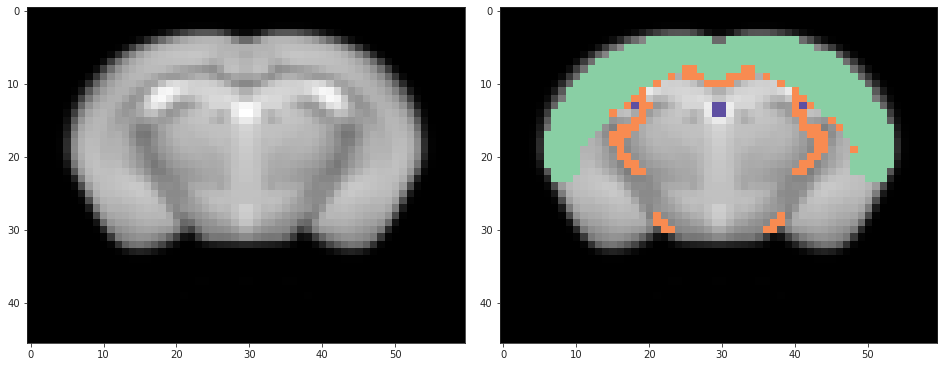

In [41]:
fig, axes = create_figure(1, 2, (13, 5), constrained_layout=True)
s_ = 37
for ax in axes.flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[1].imshow(mwh(obj[s_] == 0, obj[s_]), alpha=1, vmin=1.5, vmax=3.5, cmap='Spectral_r')
plt.show()

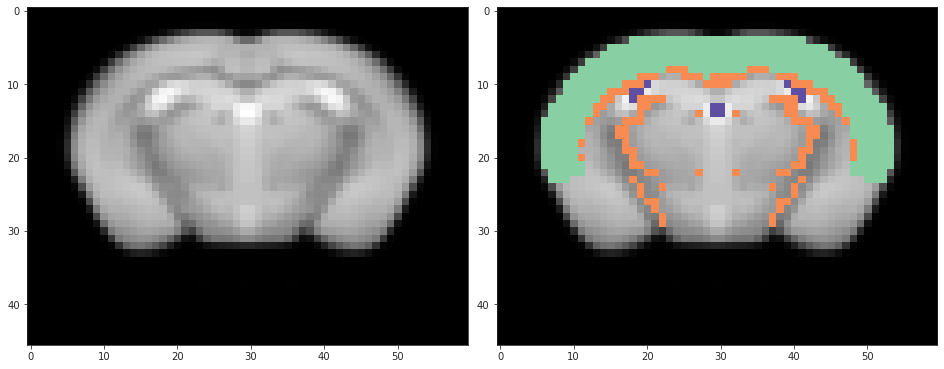

In [46]:
# Was with 25um

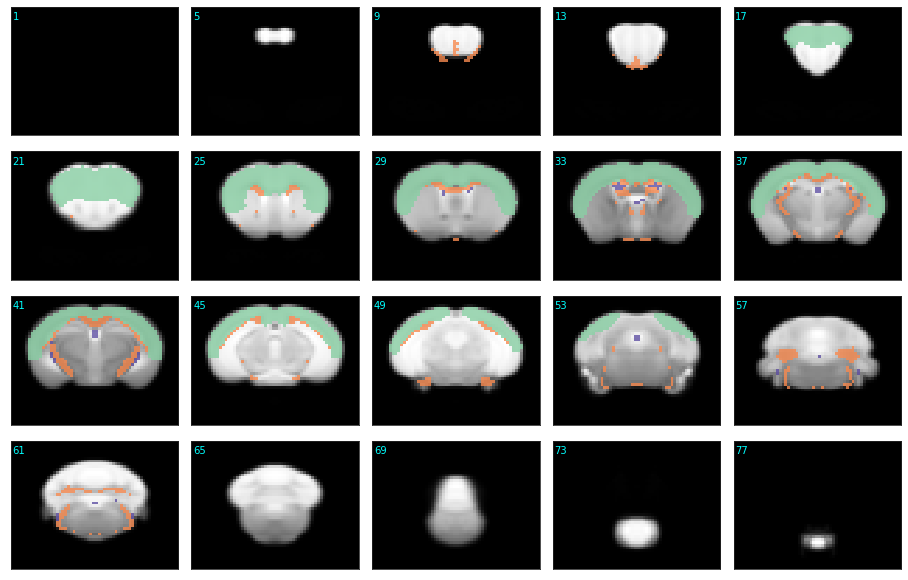

In [42]:
coronal()

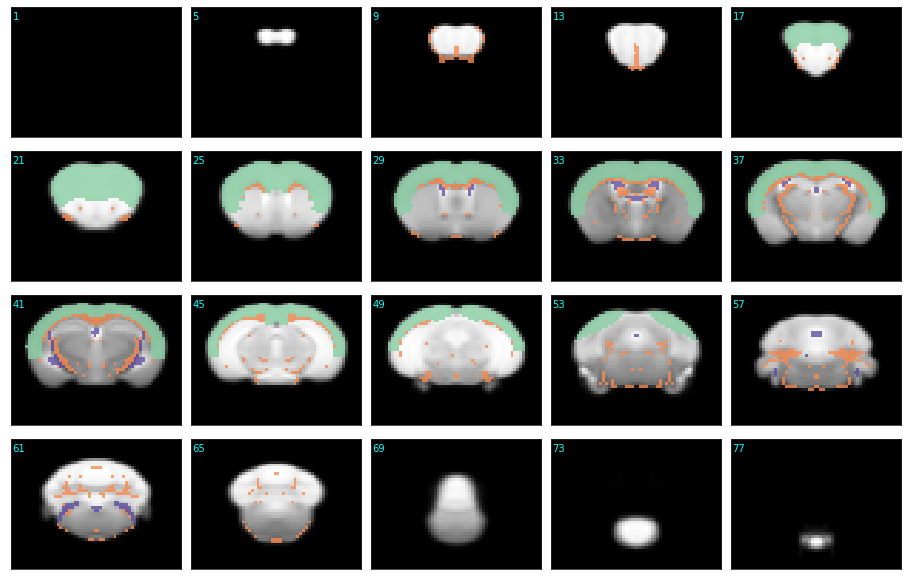

In [47]:
# Was with 25um

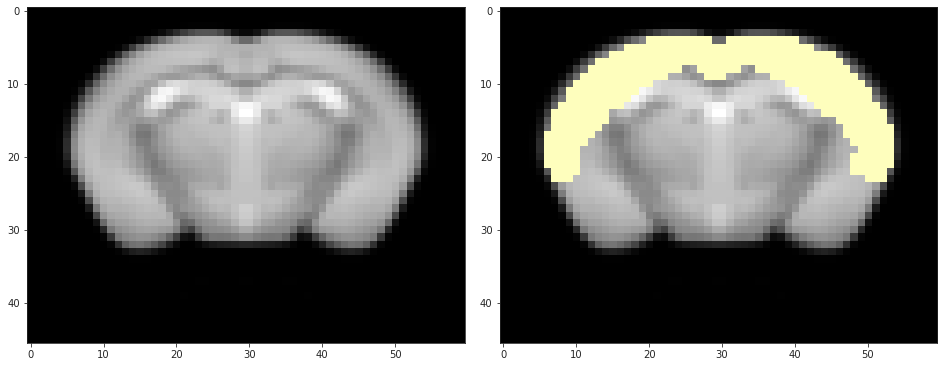

In [43]:
fig, axes = create_figure(1, 2, (13, 5), constrained_layout=True)
s_ = 37
for ax in axes.flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[1].imshow(mwh(obj[s_] != 2, obj[s_]), alpha=1, vmin=0, vmax=4, cmap='Spectral_r')
plt.show()

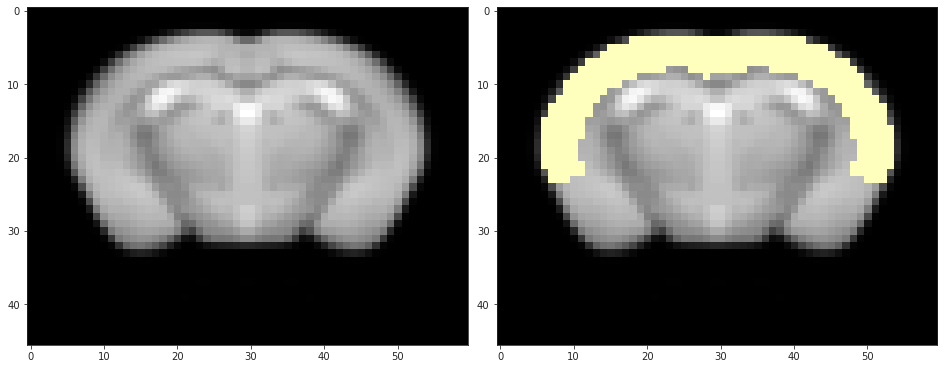

In [48]:
# Was with 25um

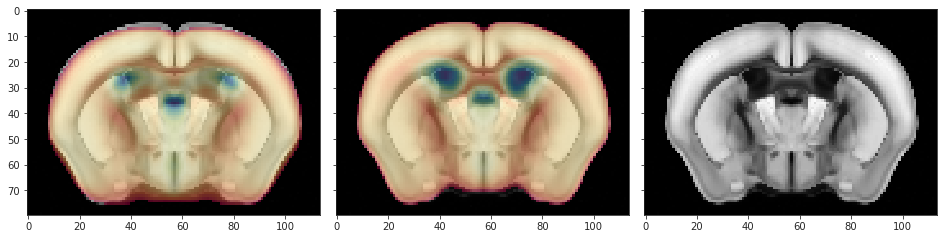

In [45]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.template[60], cmap='Greys_r')
axes[0].imshow(mwh(affined[60] < 4000, affined[60]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[60] < 4000, warped[60]), alpha=0.5, cmap='Spectral')
plt.show()

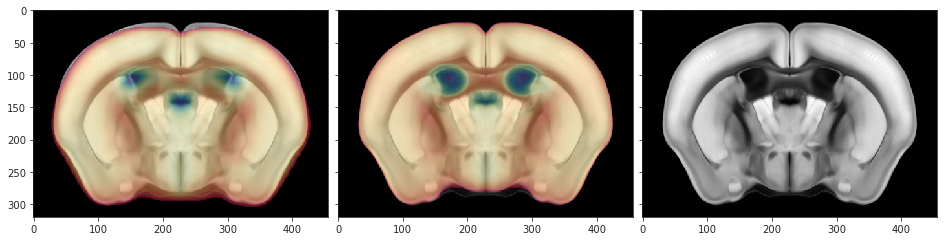

In [49]:
# Was with 25um